### Example: Testing 3D Pattern Recognition

This example demonstrates how to use the Shape_3D and finder_3D classes to detect a known 3D pattern within a larger 3D dataset (target). The aim is to test the ability of the model to:

- Recognize identical patterns

- Detect rotated versions of the pattern

- Match slightly modified versions of the pattern

- Predict the future values

We generate synthetic data with controlled insertions of the pattern to validate the performance.

In [1]:
from shapefinder import Shape_3D,finder_3D
import random
import numpy as np

In [2]:
# Define a small 3D pattern array `test` (shape: 2x3x4)
test = np.array([
    [[0.36363636, 0.45454545, 0.18181818, 0.        ],
     [0.27272727, 0.09090909, 0.        , 0.        ],
     [0.        , 0.        , 0.        , 1.        ]],

    [[0.        , 0.        , 0.        , 0.        ],
     [0.18181818, 0.        , 0.90909091, 0.        ],
     [0.        , 0.27272727, 0.        , 0.        ]]
])

We create a simulated historical data with random values from 0 to 1 and filing it with 80% of zeros. Then, we include artificially patterns that we know are close to the input pattern, with three differences :

1. A rotated version of the pattern is inserted to test rotation-invariance.

2. A modified version with an extra zero row tests structural tolerance.

3. A scaled version tests sensitivity to intensity changes.

In [3]:
# Dimensions of the test pattern
sx, sy, sz = test.shape

# Create a larger 3D array (`target`) filled with mostly zeros
target_shape = (20, 20, 20)
target = np.random.rand(*target_shape)

# Create a mask to sparsify the target (80% of values set to 0)
mask = np.random.rand(*target_shape) < 0.8
target[mask] = 0

# Insert known patterns into the target at specified locations
positions = [(4, 10, 10), (8, 6, 4), (12, 1, 4)]
for i in positions:
    x, y, z = i
    if i == positions[1]:
        # Insert a rotated version (180° around axes 0 and 1)
        test2 = np.rot90(test, k=2, axes=(0, 1))
        target[x:x+sx, y:y+sy, z:z+sz] = test2
    elif i == positions[2]:
        # Insert a modified version with a padded zero row in axis 1
        test_mod = np.concatenate((test[:, :2, :], np.zeros((2, 1, 4)), test[:, 2:, :]), axis=1)
        target[x:x+sx, y:y+sy+1, z:z+sz] = test_mod
    else:
        # Insert a scaled down version (divided by 2)
        target[x:x+sx, y:y+sy, z:z+sz] = test / 2

In [4]:
# Instantiate a shape object and load the pattern
shape3D = Shape_3D()
shape3D.set_shape(test)

In [5]:
# We plot the input Shape. The 3D shape opens in the browser. 
shape3D.plot()

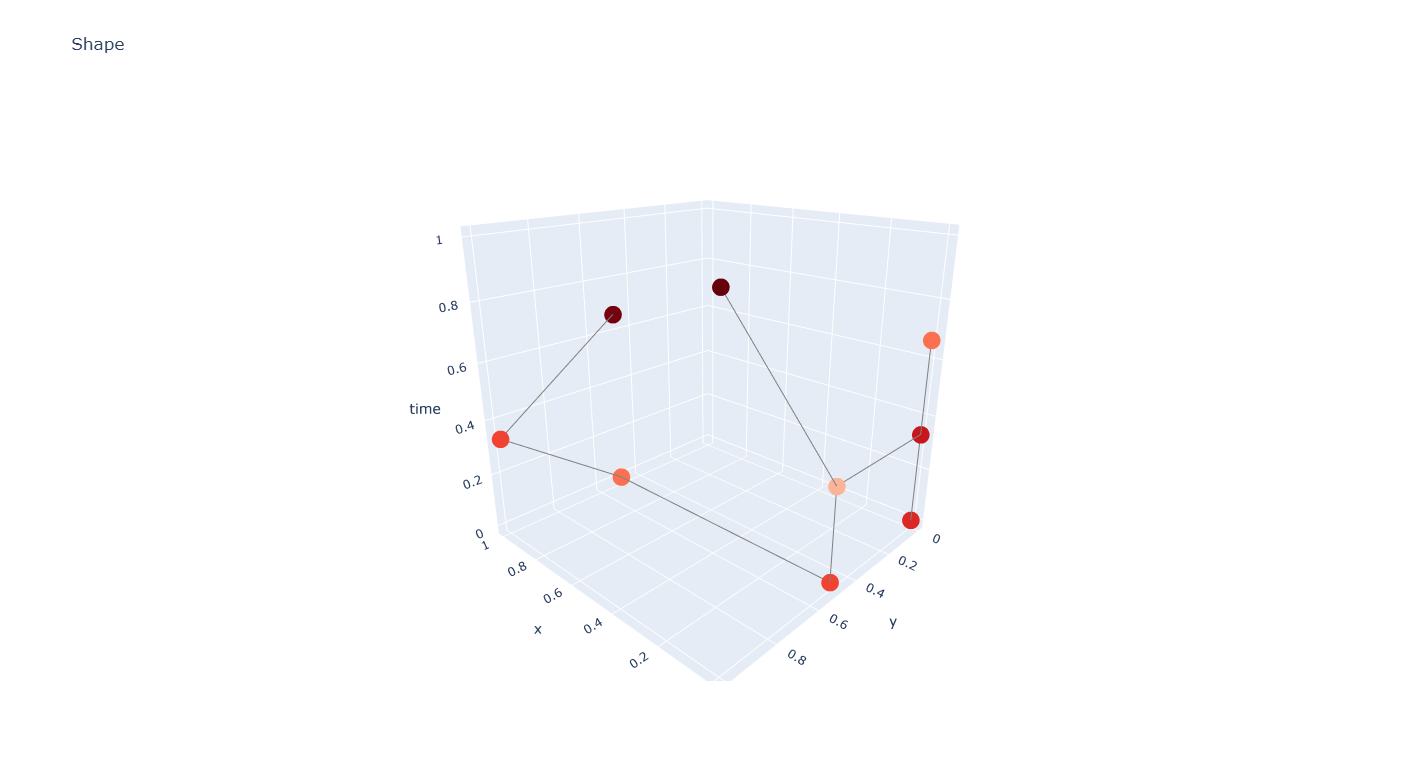

In [6]:
# Initialize the finder with the target and the reference shape
finder = finder_3D(target, Shape_3D=shape3D)

# Search for matches using Earth Mover's Distance (EMD) as distance. 
# Only the patterns with less than 0.1 are classified as similar pattern.
# 

finder.find_patterns(mode='emd', min_emd=0.1, min_mat=3)

In [7]:
# Show the similar patterns as a DataFrame. Columns 0 to 5 repesnted the values [x_min,x_max,y_min,y_max,time_min,time_max].
# The Columns 6 is the EMD value, 8 is the Ratio of active cells and 7 is the best rotation found by the model. 
print(finder.sequences)
test = finder.sequences.iloc[:,[0,2,4,6,7]]
test.columns=['x','y','time','EMD','rotation']
print(test)

        0   1   2   3   4   5         6  7    8       Sum
13227   4   6  10  13  10  14  0.000000  0  0.0  0.000000
23605   8  10   6   9   4   8  0.000000  2  0.0  0.000000
34209  12  14   1   5   4   8  0.065041  0  0.0  0.065041
        x   y  time       EMD  rotation
13227   4  10    10  0.000000         0
23605   8   6     4  0.000000         2
34209  12   1     4  0.065041         0


In [8]:
# And now we compare with the positions we inserted specified locations. 
print(positions)

[(4, 10, 10), (8, 6, 4), (12, 1, 4)]


The model found well the positions of similar patterns, as well as the rotation of the rotated pattern (k=2) and the scaled down version. The version with a padded zero row in axis 1 is not a perfect match (EMD=0), as it is not the exact same pattern, but the flexibility of the model still classifty it as similar pattern (EMD<0.1). 

In [9]:
pred = finder.predict(h=3,thres_clu=10)
finder.plot_predict()

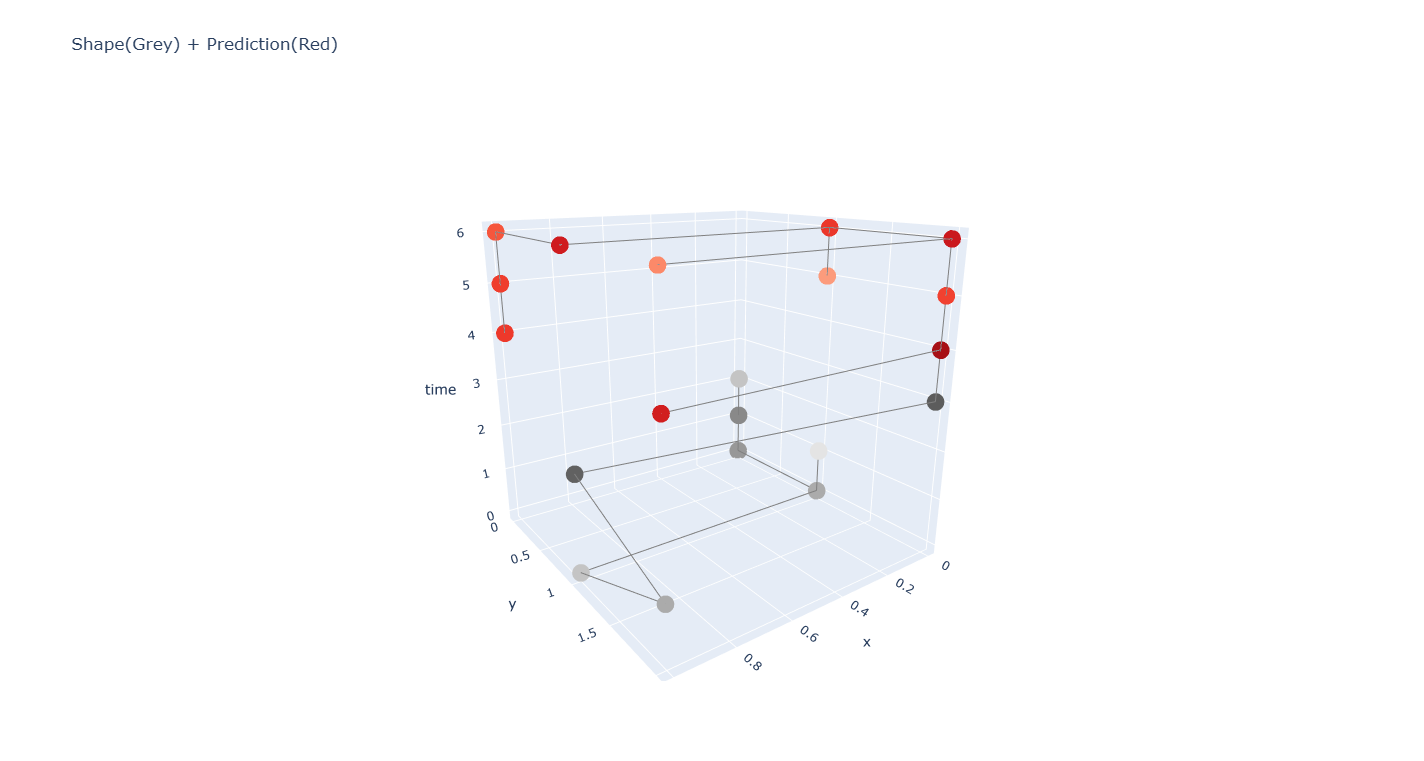